# Trading Simulation

The model's performance will now be compared to two benchmark trading strategies, over the 252 day test set (10/01/2015 - 09/29/2016):

- Buy and hold - the index is purchased at the opening price on the first day of the test period and then sold at the closing price of the last day of the test period.
- Buy only - since always buying has a slight (52-54%) accuracy advantage over selling, the index is bought each day at the opening price and then sold at the closing price. This strategy is repeated each day, in contrast to the 'buy and hold' approach, which involves a single buy and a single sell event.

The model itself is evaluated as follows: if the model predicts the price will close higher, then the index is bought at the open and sold at the close. If the model predicts the price will close lower, then the index is sold at the open and bought at the close.

As it turns out that **Random Forest** are the best performing technique, we will use it for the trading simulation. 


In [1]:
# matlotlib inline plotting
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display

import seaborn as sns

In [3]:
dataset = pd.read_csv("data/curated_all_fields_dataset.csv", sep="\t", header=0, index_col = 0)
print ("Number of data points:", len(dataset))

Number of data points: 2678


In [4]:
dataset.head(4)

,Date,SP_Open,SP_High,SP_Low,SP_Close,SP_Volume,Vix_Open,Vix_High,Vix_Low,Vix_Close,...,126d_Ret,189d_Ret,252d_Ret,1d_VIX,5d_VIX,1d_Rel_Vol,5d_Rel_Vol,1d_PtT,1d_VIX_PtT,Intraday_Increase
0,2016-09-29,2168.90,2172.67,2145.20,2151.13,4249220000,12.53,15.69,12.14,14.02,...,0.054196,0.044752,0.152477,-0.054198,-0.068421,0.150982,-0.002956,0.009513,0.105180,0
1,2016-09-28,2161.85,2172.40,2151.79,2171.37,3891460000,12.90,13.57,12.24,12.39,...,0.046503,0.050294,0.147818,-0.096552,-0.177136,-0.003421,-0.000493,0.009094,0.135299,1
2,2016-09-27,2146.04,2161.13,2141.55,2159.93,3437770000,13.36,14.76,12.97,13.10,...,0.044326,0.041296,0.111197,0.179821,-0.066323,-0.062535,-0.016959,0.006272,0.098703,1
3,2016-09-26,2158.54,2158.54,2145.04,2146.10,3216170000,13.26,14.63,13.26,14.50,...,0.062659,0.048637,0.120301,0.022463,-0.200390,-0.022102,-0.021904,0.004509,0.053520,0


#### Format data needed for trading profit calculations

In [6]:
data252days = dataset.drop('Intraday_Increase', axis = 1)
data252days = data252days[0:252]

#### Read in the classifier predictions:

In [10]:
#clf in {NN, RF, DT, SVM}
clf = "RF"

clf_trading_data = pd.read_csv("data/eval-{}.csv".format(clf),header=None)

In [11]:
if clf == "NN":
    # If column 1 > column 0, then the label (prediction) is '1' (i.e. S&P500 is predicted to increase that day)
    clf_trading_data['Predicted_Up'] = clf_trading_data[1]
    clf_trading_data['Predicted_Up'] = clf_trading_data['Predicted_Up'].apply(lambda x: 1 if x > 0.5 else 0)
else:
    clf_trading_data['Predicted_Up'] = clf_trading_data[0]
    
clf_trading_data.head(10)

,0,Predicted_Up
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,0.0,0.0
4,0.0,0.0
5,1.0,1.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,0.0,0.0


#### Append the model predictions to the market data:

In [12]:
data252days['Predicted_Up'] = clf_trading_data['Predicted_Up']
data252days.head(4)

,Date,SP_Open,SP_High,SP_Low,SP_Close,SP_Volume,Vix_Open,Vix_High,Vix_Low,Vix_Close,...,126d_Ret,189d_Ret,252d_Ret,1d_VIX,5d_VIX,1d_Rel_Vol,5d_Rel_Vol,1d_PtT,1d_VIX_PtT,Predicted_Up
0,2016-09-29,2168.90,2172.67,2145.20,2151.13,4249220000,12.53,15.69,12.14,14.02,...,0.054196,0.044752,0.152477,-0.054198,-0.068421,0.150982,-0.002956,0.009513,0.105180,1.0
1,2016-09-28,2161.85,2172.40,2151.79,2171.37,3891460000,12.90,13.57,12.24,12.39,...,0.046503,0.050294,0.147818,-0.096552,-0.177136,-0.003421,-0.000493,0.009094,0.135299,1.0
2,2016-09-27,2146.04,2161.13,2141.55,2159.93,3437770000,13.36,14.76,12.97,13.10,...,0.044326,0.041296,0.111197,0.179821,-0.066323,-0.062535,-0.016959,0.006272,0.098703,1.0
3,2016-09-26,2158.54,2158.54,2145.04,2146.10,3216170000,13.26,14.63,13.26,14.50,...,0.062659,0.048637,0.120301,0.022463,-0.200390,-0.022102,-0.021904,0.004509,0.053520,0.0


#### Reverse the dataframe order, so dates go from oldest to newest:


In [13]:
data252days = data252days.iloc[::-1]

#### Compute cummulative performance

- Buy and Hold
- Buy only

In [14]:
data252days['Cum_Buy_Hold_Profit'] = data252days['SP_Close'] - data252days['SP_Open'][251]

data252days['Buy_Profit'] = data252days['SP_Close'] - data252days['SP_Open']
data252days['Cum_Buy_Profit'] = np.cumsum(data252days['Buy_Profit'])

#### Classifier results

Model profit is equal to the buy only profit, adjusted with a negative sign if the event is a sell instead:

In [15]:
data252days['Model_Profit'] = data252days['Buy_Profit'] * (2*data252days['Predicted_Up'] - 1 )

data252days['Cum_Model_Profit'] = np.cumsum(data252days['Model_Profit'])

In [17]:
print("Cumulative Buy and Hold Strategy Profit ($):", data252days['Cum_Buy_Hold_Profit'][0])
print("Cumulative Buy Only Strategy Profit ($):", data252days['Cum_Buy_Profit'][0])
print("Cumulative Machine Learning Strategy Profit ($):", data252days['Cum_Model_Profit'][0])


Cumulative Buy and Hold Strategy Profit ($): 231.48
Cumulative Buy Only Strategy Profit ($): 234.98
Cumulative Machine Learning Strategy Profit ($): 1375.52


#### Plot the cumulative performance of the ML trading strategy compared to the benchmarks:


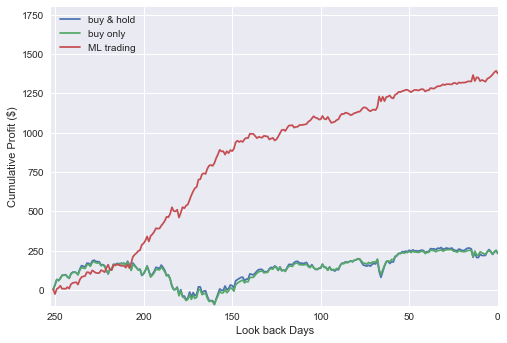

In [18]:
trading_data = data252days

plt.axis([252,0,-100,1800])

plt.plot(trading_data['Cum_Buy_Hold_Profit'], label = 'buy & hold')
plt.plot(trading_data['Cum_Buy_Profit'], label = 'buy only')
plt.plot(trading_data['Cum_Model_Profit'], label = 'ML trading')

plt.ylabel('Cumulative Profit ($)')
plt.xlabel('Look back Days')
plt.legend(loc=2)

In [19]:
print("Buy Only Daily Profit Summary Statistics:")
display(trading_data['Cum_Buy_Profit'].describe())
print("\n")
print("ML Trading Daily Profit Summary Statistics:")
display(trading_data['Model_Profit'].describe())

Buy Only Daily Profit Summary Statistics:


count    252.000000
mean     136.591667
std       87.163821
min      -91.940000
25%       95.980000
50%      147.525000
75%      192.690000
max      257.470000
Name: Cum_Buy_Profit, dtype: float64



ML Trading Daily Profit Summary Statistics:


count    252.000000
mean       5.458413
std       15.542093
min      -50.060000
25%       -2.885000
50%        4.050000
75%       14.125000
max       66.400000
Name: Model_Profit, dtype: float64

# Function to easily simulate trading

In [35]:
def getProfitDaysTradingSimulation(clf, days, dataset):  
    data252days = dataset.drop('Intraday_Increase', axis = 1)
    data252days = data252days[0 : days]
    
    clf_trading_data = pd.read_csv("data/eval-{}.csv".format(clf),header=None)
    if clf == "NN":
        clf_trading_data['Predicted_Up'] = clf_trading_data[1]
        clf_trading_data['Predicted_Up'] = clf_trading_data['Predicted_Up'].apply(lambda x: 1 if x > 0.5 else 0)
    else:
        clf_trading_data['Predicted_Up'] = clf_trading_data[0]
    
    data252days['Predicted_Up'] = clf_trading_data['Predicted_Up']
    data252days = data252days.iloc[::-1]
    data252days['Cum_Buy_Hold_Profit'] = data252days['SP_Close'] - data252days['SP_Open'][251]
    data252days['Buy_Profit'] = data252days['SP_Close'] - data252days['SP_Open']
    data252days['Cum_Buy_Profit'] = np.cumsum(data252days['Buy_Profit'])
    data252days['Model_Profit'] = data252days['Buy_Profit'] * (2*data252days['Predicted_Up'] - 1 )
    data252days['Cum_Model_Profit'] = np.cumsum(data252days['Model_Profit'])
    
    print("Cumulative Buy and Hold Strategy Profit ($):", data252days['Cum_Buy_Hold_Profit'][0])
    print("Cumulative Buy Only Strategy Profit ($):", data252days['Cum_Buy_Profit'][0])
    print("Cumulative Machine Learning Strategy Profit ($):", data252days['Cum_Model_Profit'][0])
    
    trading_data = data252days

    plt.axis([days, 0, -100, 1800])

    plt.plot(trading_data['Cum_Buy_Hold_Profit'], label = 'buy & hold')
    plt.plot(trading_data['Cum_Buy_Profit'], label = 'buy only')
    plt.plot(trading_data['Cum_Model_Profit'], label = 'ML trading')

    plt.ylabel('Cumulative Profit ($)')
    plt.xlabel('Look back Days')
    plt.legend(loc=2)
    
    plt.savefig("../figs/simulation_{}.png".format(clf))

Cumulative Buy and Hold Strategy Profit ($): 231.48
Cumulative Buy Only Strategy Profit ($): 234.98
Cumulative Machine Learning Strategy Profit ($): 1244.52


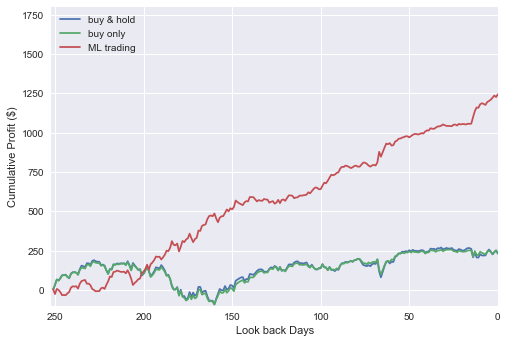

In [36]:
getProfitDaysTradingSimulation("NN", 252, dataset)

Cumulative Buy and Hold Strategy Profit ($): 231.48
Cumulative Buy Only Strategy Profit ($): 234.98
Cumulative Machine Learning Strategy Profit ($): 1299.68


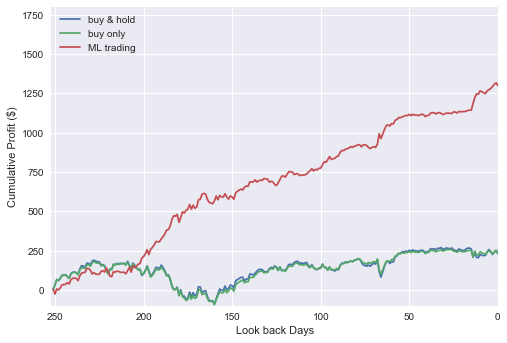

In [37]:
getProfitDaysTradingSimulation("DT", 252, dataset)

Cumulative Buy and Hold Strategy Profit ($): 231.48
Cumulative Buy Only Strategy Profit ($): 234.98
Cumulative Machine Learning Strategy Profit ($): 1459.42


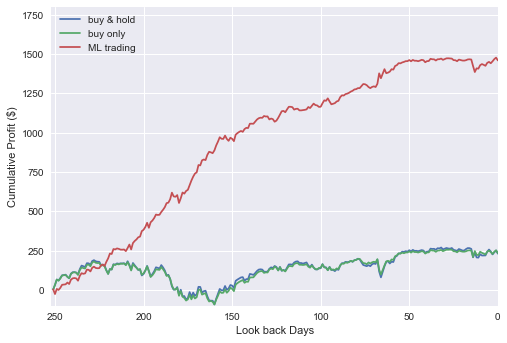

In [38]:
getProfitDaysTradingSimulation("SVM", 252, dataset)

Cumulative Buy and Hold Strategy Profit ($): 231.48
Cumulative Buy Only Strategy Profit ($): 234.98
Cumulative Machine Learning Strategy Profit ($): 1375.52


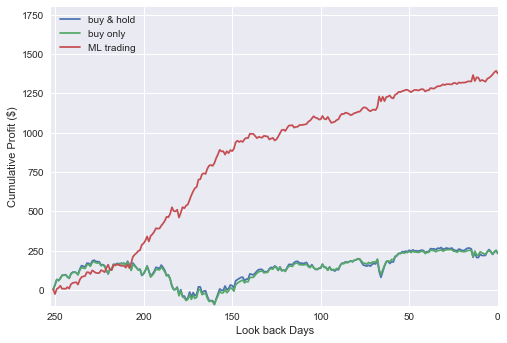

In [39]:
getProfitDaysTradingSimulation("RF", 252, dataset)